# 🐍 | Python Version

In [3]:
import sys

print("Python:", sys.version)

Python: 3.12.9 | packaged by Anaconda, Inc. | (main, Feb  6 2025, 18:49:16) [MSC v.1929 64 bit (AMD64)]


# 🛠 | Install Libraries

In [ ]:
!pip install requirements.txt

# 📚 | Import Libraries

In [4]:
import warnings

warnings.filterwarnings("ignore")

In [ ]:
import os
import pandas as pd

import peptdeep
import alphaviz
from peptdeep.model.ms2 import ModelMS2Bert
from alphaviz.plotting import plot_chrom
from peptdeep.model.ms2 import calc_ms2_similarity

## Library Version

In [5]:
print("Peptdeep:", peptdeep.__version__)
print("Alphaviz:", alphaviz.__version__)

Peptdeep: 1.3.1
Alphaviz: 1.1.15


# 📁 | Dataset Path 

In [6]:
DATASET_PATH = "quant_data/txt-DDA-analyses"

# 📖 | Meta Data

Raw quantification files from MaxQuant:

- `evidence.txt`

  The evidence file combines all the information about the identified peptides and normally is the only file
  required for processing the results. Additional information about the peptides, modifications, proteins, etc. can
  be found in the other files by unique identifier linkage.
  - Sequence, Modified sequence: Peptide sequence and its modifications
  - Charge, Mass error [ppm], Retention time, m/z
  - Raw file: Raw file name
  - Missed cleavages: Number of missed enzymatic cleavages
  - Gene names: Names of genes this peptide is associated with
  - Protein names: Names of proteins this peptide is associated with
  - MS/MS scan number: The RAW-file derived scan number of the MS/MS with the highest peptide identification score (the highest score is stored in the column 'Score')
  - id: A unique (consecutive) identifier for each row in the evidence table
  - Protein group IDs: The identifier of the protein-group this redundant peptide sequence is associated with
  - Peptide ID: The identifier of the non-redundant peptide sequence.
  - MS/MS IDs:  Identifier(s) of the associated MS/MS summary(s) stored in the file 'msms.txt'.
  - Intensity, Experiment, etc.
- `peptides.txt`
  - id:  A unique (consecutive) identifier for each row in the peptides table
  - Reverse: When marked with '+', this particular peptide was found to be part of a protein derived from the reversed part of the decoy database. These should be removed for further data analysis
  - Unique (Proteins): When marked with '+', this particular peptide is unique to a single protein sequence in the fasta file(s)
  - etc.
- `msms.txt`
  - id: A unique (consecutive) identifier for each row in the peptides table
  - Scan number: The RAW-file derived scan number of the MS/MS spectrum
  - Masses: The charge corrected mass of the precursor ion.
  - Intensities: The intensities of the peaks in the fragmentation spectrum
  - Matches: The species of the peaks in the fragmentation spectrum
  - PEP: Posterior Error Probability of the identification. This value essentially operates as a p-value, where smaller is more significant.
  - etc.
- `proteinGroups.txt`
  - id: A unique (consecutive) identifier for each row in the peptides table
  - Protein IDs: Identifier(s) of protein(s) contained in the protein group
  - etc.
- `msmsScans.txt`
  - MS/MS IDs: The identifiers of the MS/MS scans identifying this peptide
  - Collision energy: The collision energy used for the fragmentation that resulted in this MS/MS scan.
  - etc.
- `etc.`

# 🍽️ | Extract data

This step aims to extract peptide information and corresponding MS/MS spectra.
For each raw file listed in evidence.txt, three output files will be generated:
- `psm_df.csv`: Contains peptide-spectrum match (PSM) information.
    - peptide_id, sequence, charge, raw_name, spec_idx, instrument, scan_num, nAA, precursor_mz, etc.
    - mods: List type of modification (ex: Phospho@T, Oxidation@M, etc.)
    - mod_site: The position of modification (ex: 1, 4, etc.)
    - rt: Retention time of peptide
    - decoy: Check peptide is decoy (1 -> decoy, 0 -> no decoy)
    - nce: Collision energy
    - genes: Gene name
    - ProteinName
    - fragment_start_idx, fragment_stop_idx: Start and stop fragment index in fragment_*.csv 
    - etc.

- `fragment_mz_df.csv`: Includes m/z values of fragment ions.

- `fragment_intensity_df.csv`: Contains intensities of fragment ions.

In [ ]:
from src.extract_zip_data_quant import extract_peptide_info_to_separated_raw_file

In [6]:
frag_types = ['b_z1', 'b_z2', 'y_z1', 'y_z2', 'b_modloss_z1', 'b_modloss_z2', 'y_modloss_z1', 'y_modloss_z2']

In [ ]:
extract_peptide_info_to_separated_raw_file(path=DATASET_PATH,
    out_dir=r'psm_data/PXD014525',
    frag_types=frag_types,
    is_included_other_mods=False,
    raw_names=[], # This will process all raw files
    instrument='QE'
)

'''
    With raw_name: '20171001_QE3_nLC7_DBJ_SA_LFQphos_Tech_Rep_01', output contains:
    'psm_data/PXD014525/20171001_QE3_nLC7_DBJ_SA_LFQphos_Tech_Rep_01_1/psm_df.csv',
    'psm_data/PXD014525/20171001_QE3_nLC7_DBJ_SA_LFQphos_Tech_Rep_01_1/fragment_mz_df.csv',
    'psm_data/PXD014525/20171001_QE3_nLC7_DBJ_SA_LFQphos_Tech_Rep_01_1/fragment_intensity_df.csv',
'''

# ✅ | Save psm data with .hdf format

For serving other experiment

In [4]:
from src.utils import convert_psm_data_to_hdf

In [ ]:
for path in os.listdir('psm_data/PXD014525'):
    full_path = os.path.join('psm_data/PXD014525', path)
    convert_psm_data_to_hdf(path=full_path, out_dir='psm_data/test_hdf')

# 🍖 Load Raw DDA Data 

In [ ]:
from src.read_raw_file import RawFile

In [ ]:
raw = r"psm_data\PXD014525\2.raw_dda_data\20171001_QE3_nLC7_DBJ_SA_LFQphos_LCMS_Rep_01.raw"
raw_data = RawFile(raw)

chromatograms_plot = plot_chrom(raw_data, colorscale_qualitative="Bold")
chromatograms_plot

# 🤖 | Modeling

In [5]:
from src.custom_model import CustomModelManager, CustompDeepModel


ms2_model = CustompDeepModel(charged_frag_types=frag_types, mask_modloss=False,model_class=ModelMS2Bert, modloss_type=["modloss", 'NH3', 'H2O'])
modelMans = CustomModelManager(mask_modloss= False, ms2_model=ms2_model)
no_tuned_ms2_model = CustompDeepModel(charged_frag_types=frag_types, mask_modloss=True,model_class=ModelMS2Bert, modloss_type=["modloss", 'NH3', 'H2O'])
no_tuned_modelMans = CustomModelManager(mask_modloss= True, ms2_model=no_tuned_ms2_model)

# 🚊 | Load AlphaPeptdeep pretrained model

In [ ]:
no_tuned_modelMans.rt_model.load('pretrained_models/generic/rt.pth')
no_tuned_modelMans.ccs_model.load('pretrained_models/generic/ccs.pth')
no_tuned_modelMans.ms2_model.load('pretrained_models/generic/ms2.pth')

modelMans.rt_model.load('pretrained_models/generic/rt.pth')
modelMans.ccs_model.load('pretrained_models/generic/ccs.pth')
modelMans.ms2_model.load('pretrained_models/generic/ms2.pth')

# 🚂 | Training

In [13]:
ITER_TIMES = 2
PSM_DATASET_PATH = "psm_data/PXD014525"
EPOCH = 100
BATCH_SIZE = 256
LEARNING_RATE = 5e-4

In [12]:
# List of psm data
os.listdir(PSM_DATASET_PATH)

['0.raw_dia_data',
 '1.mzML_dia_data',
 '2.raw_dda_data',
 '20170517_QE5_nLC7_DBJ_SA_LFQphos_Hela_TiO2_15min_15000_01',
 '20170517_QE5_nLC7_DBJ_SA_LFQphos_Hela_TiO2_15min_15000_02',
 '20171001_QE3_nLC7_DBJ_SA_LFQphos_LCMS_Rep_01',
 '20171001_QE3_nLC7_DBJ_SA_LFQphos_LCMS_Rep_02',
 '20171001_QE3_nLC7_DBJ_SA_LFQphos_LCMS_Rep_03',
 '20171001_QE3_nLC7_DBJ_SA_LFQphos_LCMS_Rep_04',
 '20171001_QE3_nLC7_DBJ_SA_LFQphos_LCMS_Rep_05',
 '20171001_QE3_nLC7_DBJ_SA_LFQphos_LCMS_Rep_06',
 '20171001_QE3_nLC7_DBJ_SA_LFQphos_Tech_Rep_01',
 '20171001_QE3_nLC7_DBJ_SA_LFQphos_Tech_Rep_02',
 '20171001_QE3_nLC7_DBJ_SA_LFQphos_Tech_Rep_03',
 '20171001_QE3_nLC7_DBJ_SA_LFQphos_Tech_Rep_04',
 '20171001_QE3_nLC7_DBJ_SA_LFQphos_Tech_Rep_05',
 '20171001_QE3_nLC7_DBJ_SA_LFQphos_Tech_Rep_06',
 '20171024_QE5_nLC3_DBJ_SA_LFQphos_RPE1_Pilot2_Cobimetinib_0-5uM_01',
 '20171024_QE5_nLC3_DBJ_SA_LFQphos_RPE1_Pilot2_Cobimetinib_0-5uM_02',
 '20171024_QE5_nLC3_DBJ_SA_LFQphos_RPE1_Pilot2_Cobimetinib_0-5uM_03',
 '20171024_QE5_nLC3_

In [ ]:
for _ in range(ITER_TIMES):
  for file in os.listdir(PSM_DATASET_PATH):
    dir = f"{PSM_DATASET_PATH}/{file}"
    
    # Skip if not a directory or not a psm data or not the first experiment
    if not os.path.isdir(dir) or file[1] == '.' or file[-1] != '1':
      continue

    print(f"-- {file} --")
    psm_df = pd.read_csv(f'{dir}/psm_df.csv')
    psm_df['mod_sites'] = psm_df['mod_sites'].astype(str)
    psm_df['mod_sites'].fillna('', inplace=True)
    psm_df['mods'] = psm_df['mods'].astype(str)
    psm_df['mods'].fillna('', inplace=True)
    psm_df['mods'] = psm_df['mods'].apply(lambda x: x.replace('Acetyl@Protein N-term', 'Acetyl@Protein_N-term'))
    intensity_df = pd.read_csv(f'{dir}/fragment_intensity_df.csv')

    modelMans.ms2_model.train(precursor_df=psm_df, fragment_intensity_df=intensity_df,
      batch_size=BATCH_SIZE, lr=LEARNING_RATE, epoch=EPOCH, verbose=True)

### 📊 | Compare metrics of two model (pretrained model vs tuned model)

In [ ]:
from src.visualization import compare_metrics

With `20171001_QE3_nLC7_DBJ_SA_LFQphos_LCMS_Rep_02` experiment

In [ ]:
psm_df = pd.read_csv(f'psm_data/PXD014525/20171001_QE3_nLC7_DBJ_SA_LFQphos_LCMS_Rep_01/psm_df.csv')
psm_df.fillna('', inplace=True)
psm_df['mod_sites'] = psm_df['mod_sites'].astype(str)
psm_df['mod_sites'].fillna('', inplace=True)
psm_df['mods'] = psm_df['mods'].astype(str)
psm_df['mods'].fillna('', inplace=True)
psm_df['mods'] = psm_df['mods'].apply(lambda x: x.replace('Acetyl@Protein N-term', 'Acetyl@Protein_N-term'))

intensity_df = pd.read_csv(f'psm_data/PXD014525/20171001_QE3_nLC7_DBJ_SA_LFQphos_LCMS_Rep_01/fragment_intensity_df.csv')

In [ ]:
no_tuned_pred_intensities = no_tuned_modelMans.predict_ms2(precursor_df=psm_df)

no_tuned_result_psm, no_tuned_metrics = calc_ms2_similarity(
    psm_df, predict_intensity_df=no_tuned_pred_intensities, fragment_intensity_df=intensity_df
)

2025-05-16 06:41:22> Predicting MS2 ...


100%|██████████| 49/49 [00:08<00:00,  6.02it/s]


In [ ]:
pred_intensities = modelMans.predict_ms2(precursor_df=psm_df)

tuned_result_psm, tuned_metrics = calc_ms2_similarity(
    psm_df, predict_intensity_df=pred_intensities, fragment_intensity_df=intensity_df
)

2025-05-16 06:41:31> Predicting MS2 ...


100%|██████████| 49/49 [00:09<00:00,  5.13it/s]


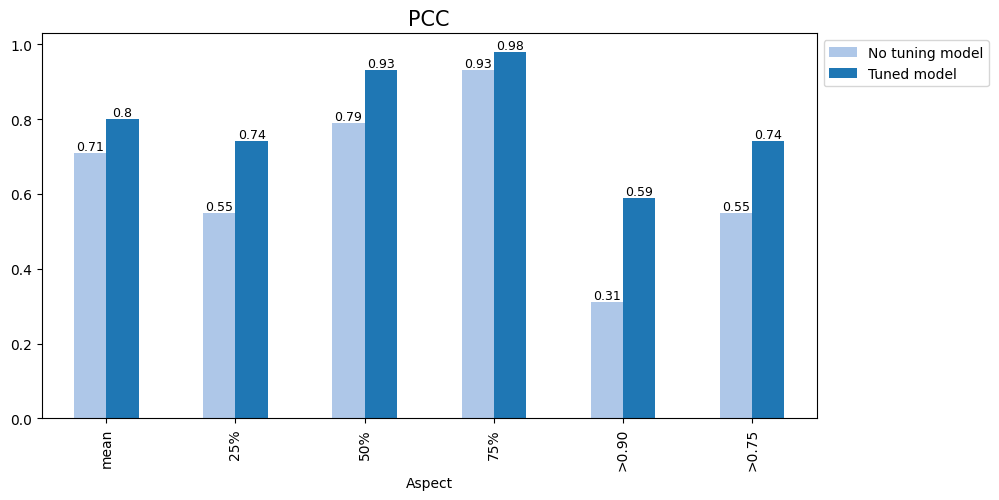

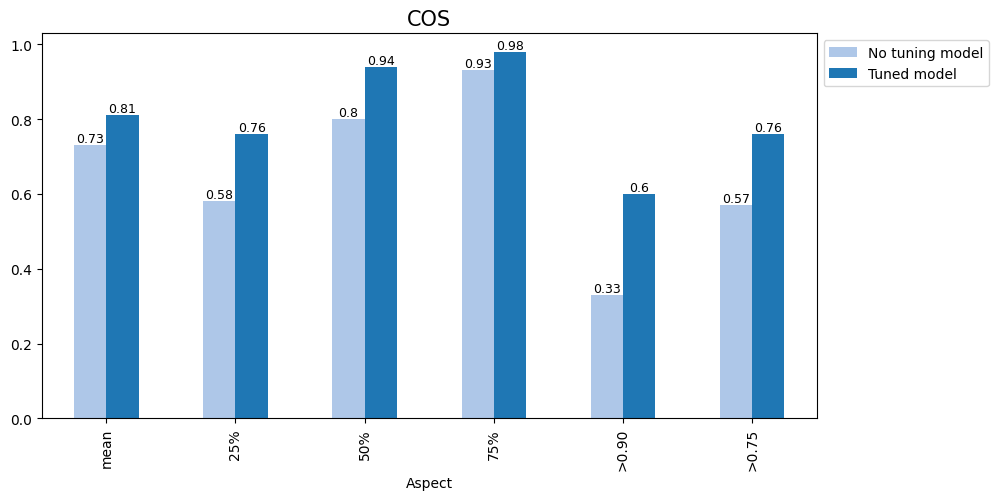

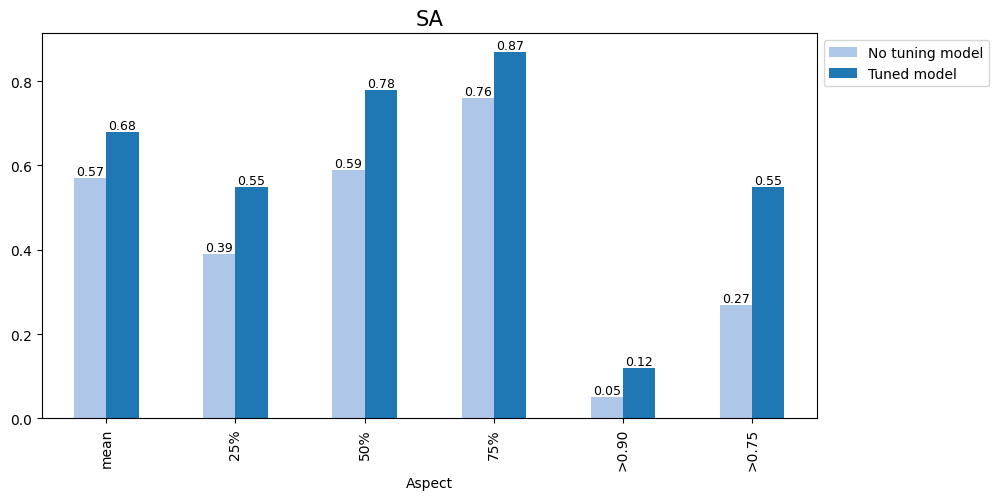

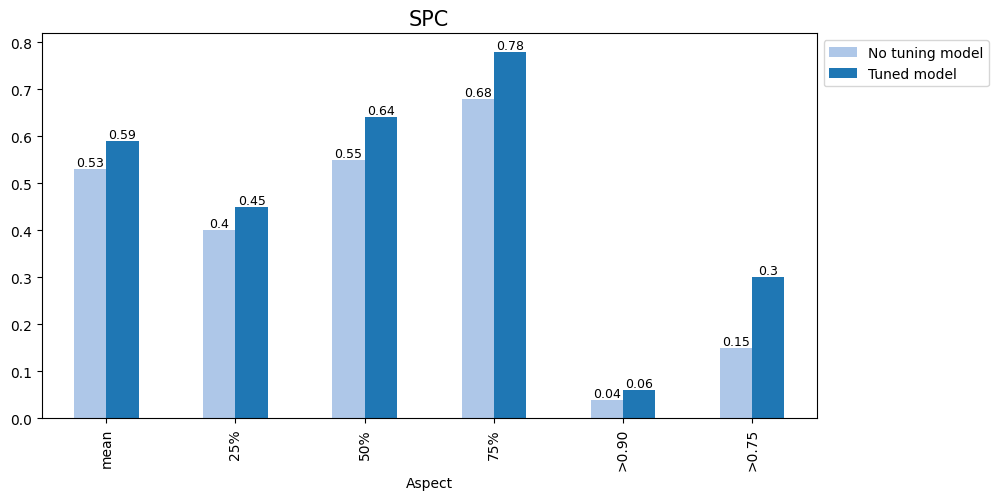

In [ ]:
compare_metrics(
    first_metrics=no_tuned_metrics,
    second_metrics=tuned_metrics,
    first_label_title='No tuning model',
    second_label_title='Tuned model',
    evaluations=['PCC', 'COS', 'SA', 'SPC']
)

### 📊 | Compare spectra of specific peptide

In [ ]:
from src.visualization import mirror_plot, predict_one_peptide, get_frag_to_plot

In [ ]:
def get_seq_df(psm_df, seq, mods, mod_sites, charge, nce):
    _df = psm_df.sort_values('PCC', ascending=False).reset_index(drop=True)
    return _df[
            (_df.sequence==seq)&(_df.mods==mods)&(_df.mod_sites==mod_sites)&(_df.charge==charge)&((_df.nce-nce).abs()<0.0001)
    ]

def get_spec_idx(seq_df, ith):
    spec_idx, pcc,_raw_name = seq_df[['spec_idx','PCC','raw_name']].values[ith]
    return spec_idx, pcc,_raw_name

In [30]:
psm_df[['sequence', 'mods', 'mod_sites', 'charge', 'nce']]

,sequence,mods,mod_sites,charge,nce
0,WFSNPSR,Phospho@S,6,2,28
1,IEDFLER,,,2,28
2,SNPDFLK,Phospho@S,1,2,28
3,IAISPLK,Phospho@S,4,2,28
4,IDIVENR,,,2,28
...,...,...,...,...,...
5667,REPAEQPGDGERTDCEPVGLEPAVEQSSAASELAEASSEELAEAPT...,Phospho@S;Carbamidomethyl@C,50;15,5,28
5668,AAAAAAAAAAAATGTEAGPGTAGGSENGSEVAAQPAGLSGPAEVGP...,Phospho@T,53,4,28
5669,AAAAAAAAAAAATGTEAGPGTAGGSENGSEVAAQPAGLSGPAEVGP...,Phospho@T,53,5,28
5670,ADRDSGSEQGGAALGSGGSLGHPGSGSGSGGGGGGGGGGGGSGGGG...,Acetyl@Protein_N-term;Phospho@S,0;5,4,28


In [ ]:
seq_to_plot = 'VVQRSSLSR'
mods = 'Phospho@S'
mod_sites = '5'
charge = 2
nce = 28.0

In [ ]:
# With no tuned model
seq_df = get_seq_df(no_tuned_result_psm, seq_to_plot, mods, mod_sites, charge, nce)

spec_idx, pcc, raw_name = get_spec_idx(seq_df,-1)
selected_peptide = psm_df[(psm_df.spec_idx==spec_idx)&(psm_df.raw_name==raw_name)].reset_index()

peptide = predict_one_peptide(selected_peptide, no_tuned_modelMans)
frag_to_plot = get_frag_to_plot(peptide)
fig = mirror_plot(raw_data[spec_idx], frag_to_plot, f"{selected_peptide['sequence'].values[0]} ({selected_peptide['sequence'].values[0]}+)", metrics=['PCC', 'COS', 'SA'])
fig.show()

2025-05-16 06:43:43> Predicting RT ...


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 51.23it/s]

2025-05-16 06:43:43> Predicting mobility ...



100%|██████████| 1/1 [00:00<00:00, 91.81it/s]

2025-05-16 06:43:43> Predicting MS2 ...



100%|██████████| 1/1 [00:00<00:00, 76.93it/s]


In [33]:
# With tuned model
seq_df = get_seq_df(tuned_result_psm, seq_to_plot, mods, mod_sites, charge, nce)

spec_idx, pcc, raw_name = get_spec_idx(seq_df,-1)
selected_peptide = psm_df[(psm_df.spec_idx==spec_idx)&(psm_df.raw_name==raw_name)].reset_index()

peptide = predict_one_peptide(selected_peptide, modelMans)
frag_to_plot = get_frag_to_plot(peptide)
fig = mirror_plot(raw_data[spec_idx], frag_to_plot, f"{selected_peptide['sequence'].values[0]} ({selected_peptide['sequence'].values[0]}+)", metrics=['PCC', 'COS', 'SA'])
fig.show()

2025-05-16 06:43:50> Predicting RT ...


100%|██████████| 1/1 [00:00<00:00, 199.93it/s]

2025-05-16 06:43:50> Predicting mobility ...



100%|██████████| 1/1 [00:00<00:00, 126.21it/s]

2025-05-16 06:43:50> Predicting MS2 ...



100%|██████████| 1/1 [00:00<00:00, 93.49it/s]


# ✏️ | Generate in silico spectral library

In [ ]:
from src.generate_spectral_lib import generate_spectral_lib

Generate spectral library without neutral loss

In [ ]:
for raw_name in os.listdir(PSM_DATASET_PATH):
    if raw_name in ['0.raw_dia_data', '1.mzML_dia_data', '2.raw_dda_data']:
        continue
    
    dir = f"{PSM_DATASET_PATH}/{raw_name}"
    print(f"-- {raw_name} --")
    psm_df = pd.read_csv(fr'{dir}\psm_df.csv')
    psm_df.fillna('', inplace=True)
    psm_df['mod_sites'] = psm_df['mod_sites'].astype(str)
    psm_df['mod_sites'].fillna('', inplace=True)
    psm_df['mods'] = psm_df['mods'].astype(str)
    psm_df['mods'].fillna('', inplace=True)
    psm_df['mods'] = psm_df['mods'].apply(lambda x: x.replace('Acetyl@Protein N-term', 'Acetyl@Protein_N-term'))
    
    mz_df = pd.read_csv(fr'{dir}\fragment_mz_df.csv')
    intensity_df = pd.read_csv(fr'{dir}\fragment_intensity_df.csv')

    generate_spectral_lib(f'spectral_library/noloss/no_loss_{raw_name}.tsv',
        no_tuned_modelMans, psm_df=psm_df, predict_items=['mobility', 'ms2'],frag_types=frag_types, multiprocessing=False)

In [ ]:
# Combine all noloss spectral libraries
from src.generate_spectral_lib import combine_spectral_lib

paths = os.listdir('spectral_library/noloss')
lib_paths = []
for x in paths:
    if x.startswith('no_loss') and 'old' not in x:
        lib_paths.append('spectral_library/noloss/' + x)

combined_noloss_spec_lib = combine_spectral_lib(
    lib_paths=lib_paths
)
combined_noloss_spec_lib.to_csv('spectral_library/no_loss_combined.tsv', sep='\t', index=False)

Generate spectral library with neutral loss

In [ ]:
for raw_name in os.listdir(PSM_DATASET_PATH):
    if raw_name in ['0.raw_dia_data', '1.mzML_dia_data', '2.raw_dda_data']:
        continue
    
    dir = f"{PSM_DATASET_PATH}/{raw_name}"
    print(f"-- {raw_name} --")
    psm_df = pd.read_csv(fr'{dir}\psm_df.csv')
    psm_df.fillna('', inplace=True)
    psm_df['mod_sites'] = psm_df['mod_sites'].astype(str)
    psm_df['mod_sites'].fillna('', inplace=True)
    psm_df['mods'] = psm_df['mods'].astype(str)
    psm_df['mods'].fillna('', inplace=True)
    psm_df['mods'] = psm_df['mods'].apply(lambda x: x.replace('Acetyl@Protein N-term', 'Acetyl@Protein_N-term'))
    
    mz_df = pd.read_csv(fr'{dir}\fragment_mz_df.csv')
    intensity_df = pd.read_csv(fr'{dir}\fragment_intensity_df.csv')

    generate_spectral_lib(f'spectral_library/neutral_loss/neutral_loss_{raw_name}.tsv',
        modelMans, psm_df=psm_df, predict_items=['mobility', 'ms2'],frag_types=frag_types, multiprocessing=False)

In [ ]:
# Combine all neutral loss spectral libraries
from src.generate_spectral_lib import combine_spectral_lib

paths = os.listdir('spectral_library/neutral_loss')
lib_paths = []
for x in paths:
    if x.startswith('neutral_loss') and 'old' not in x:
        lib_paths.append('spectral_library/neutral_loss/' + x)

combined_neutral_loss_spec_lib = combine_spectral_lib(
    lib_paths=lib_paths
)
combined_neutral_loss_spec_lib.to_csv('spectral_library/neutral_loss_combined.tsv', sep='\t', index=False)

# 🏁| End

`This in silico spectral library will be used in DIA-NN (DIA Analysis)`